In [13]:
from makiflow.layers import *
from makiflow.models.segmentation.segmentator import Segmentator
from makiflow.augmentation import AffineAugment, ElasticAugment, ImageCutter, Data
from makiflow.save_recover import Builder
from makiflow.trainers import SegmentatorTrainer
from makiflow.metrics import categorical_dice_coeff, confusion_mat
import makiflow as mf

import tensorflow as tf
import numpy as np
import glob
import cv2
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter

In [2]:
mf.set_main_gpu(1)

In [3]:
class ImageCutter:

    @staticmethod
    def image_and_mask_cutter(
        images, masks, window_h, window_w, step_x, step_y, classes_to_get,
        use_all_px=True
    ):
        """
        Crops `images` and `masks` using sliding window with resize.
        Parameters
        ----------
        images : list
            List of input images.
        masks : list
            List of input masks.
        window_h : int
            Output image height.
        window_w : int
            Output image width.
        step_x : int
            Sliding window step by OX.
        step_y : int
            Sliding window step by OX.
        scale_factor : float
            Scale factor, must be in range (0, 1). After each 'sliding window step' the original images
            are resized to (previous_width * scale_factor, previous_height * scale_factor).
        postprocessing : func
            Post processing function, using on cropped image (may be function what calculate num positives pixels).
        use_all_px : bool
            If True, all pixels of image would be in output lists.

        Returns
        -------
        Three list:
            1. cropped images
            2. cropped masks
            3. additional list (result of post processing)
        """
        assert (len(images) > 0)
        assert (len(images) == len(masks))
        assert (window_h > 0 and window_w > 0 and step_x > 0 and step_y > 0)

        cropped_images = []
        cropped_masks = []
        additional_list = []
        dx = 0
        dy = 0

        for index, (img, mask) in enumerate(zip(images, masks)):
            print(index)
            assert (img.shape[:2] == mask.shape[:2])
            current_height, current_width = img.shape[:2]


            for dy in range(int((current_height - window_h) / step_y)):
                for dx in range(int((current_width - window_w) / step_x)):
                    crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                        img,
                        mask,
                        dy * step_y, dy * step_y + window_h, dx * step_x, dx * step_x + window_w)
                    if ImageCutter.has_class(crop_mask, classes_to_get):
                        cropped_images.append(crop_img)
                        cropped_masks.append(crop_mask)

            if use_all_px:
                overlap_y = dy * step_y + window_h != current_height
                overlap_x = dx * step_x + window_w != current_width
                if overlap_y:
                    for dx in range(int((current_width - window_w) / step_x)):
                        crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                            img,
                            mask,
                            current_height - window_h, current_height, dx * step_x, dx * step_x + window_w)
                        if ImageCutter.has_class(crop_mask, classes_to_get):
                            cropped_images.append(crop_img)
                            cropped_masks.append(crop_mask)

                if overlap_x:
                    for dy in range(int((current_height - window_h) / step_y)):
                        crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                            img,
                            mask,
                            dy * step_y, dy * step_y + window_h, current_width - window_w, current_width)
                        if ImageCutter.has_class(crop_mask, classes_to_get):
                            cropped_images.append(crop_img)
                            cropped_masks.append(crop_mask)

                if overlap_x and overlap_y:
                    crop_img, crop_mask = ImageCutter.crop_img_and_mask(
                        img,
                        mask,
                        current_height - window_h, current_height, current_width - window_w, current_width)
                    if ImageCutter.has_class(crop_mask, classes_to_get):
                        cropped_images.append(crop_img)
                        cropped_masks.append(crop_mask)

        return cropped_images, cropped_masks, additional_list

    @staticmethod
    def crop_img_and_mask(img, mask, up, down, left, right):
        crop_img = img[up: down, left: right]
        crop_mask = mask[up: down, left: right]
        return crop_img, crop_mask
    
    @staticmethod
    def has_class(mask, needed):
        actual = np.unique(mask)
        for need in needed:
            if need in actual:
                return True
        return False


def normalize_data(Xtrain, Ytrain, Xtest, Ytest):
    Xtrain = np.asarray(Xtrain).astype(np.float32) / 255
    Xtrain = [i for i in Xtrain]
    Ytrain = np.asarray(Ytrain).astype(np.uint8) // 10
    Ytrain = [i for i in Ytrain]
    
    Xtest = np.asarray(Xtest).astype(np.float32) / 255
    Xtest = [i for i in Xtest]
    Ytest = np.asarray(Ytest).astype(np.uint8) // 10
    Ytest = [i for i in Ytest]
    return Xtrain, Ytrain, Xtest, Ytest

In [4]:
def load_data(path_to_data='datasets/eyes/mask'):
    Xtrain = []
    Ytrain = []

    masks = glob.glob(f'{path_to_data}/*.bmp')
    for mask_name in tqdm(masks):
        img = cv2.imread(mask_name.replace('mask', 'imgs'))
        mask = cv2.imread(mask_name)
        Xtrain.append(img)
        Ytrain.append(mask[:, :, 0])
        
    return Xtrain, Ytrain
    
def get_test_data():
    images, labels = load_data()
    imgs, lbls = [], []
    for i, (img, lbl) in enumerate(zip(images, labels)):
        if i in [2, 24, 41, 85, 75, 6, 7]:
            imgs += [img]
            lbls += [lbl]
            
    cropped_images1, cropped_masks1, _ = ImageCutter.image_and_mask_cutter(imgs, lbls,
        window_h=256, window_w=256, step_x=50, step_y=50, classes_to_get=[40, 70, 80])
    
    cropped_images2, cropped_masks2, _ = ImageCutter.image_and_mask_cutter(
        imgs, lbls, window_h=256, window_w=256, step_x=40, step_y=40, classes_to_get=[70])
    
    cropped_images3, cropped_masks3, _ = ImageCutter.image_and_mask_cutter(
        imgs, lbls, window_h=256, window_w=256, step_x=60, step_y=60, classes_to_get=[60])
    
    cropped_images4, cropped_masks4, _ = ImageCutter.image_and_mask_cutter(
        imgs, lbls, window_h=256, window_w=256, step_x=60, step_y=60, classes_to_get=[10])
        
    cropped_images = cropped_images1 + cropped_images2 + cropped_images3 + cropped_images4 + cropped_images1[:18]
    cropped_masks = cropped_masks1 + cropped_masks2 + cropped_masks3 + cropped_masks4 + cropped_masks1[:18]
    print(len(cropped_images))
    assert(len(cropped_images) % 8 == 0)
    return cropped_images, cropped_masks

In [5]:
Xtest, Ytest = get_test_data()

100%|██████████| 100/100 [00:00<00:00, 189.93it/s]


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
744


In [6]:
Xtest = np.asarray(Xtest).astype(np.float32) / 255
Xtest = [i for i in Xtest]
Ytest = np.asarray(Ytest).astype(np.uint8) // 10
Ytest = [i for i in Ytest]

In [7]:
model = Builder.segmentator_from_json('Models/Resnet50.json', batch_size=8)

Model is restored!


In [8]:
model.set_session(tf.Session())

In [9]:
model.load_weights('Augmentation 1 Resnet50/experiments/Augmnetation 1/MakiSegmentator_gamma=4.0_lr=0.001_bsz=32/last_weights/weights.ckpt')

INFO:tensorflow:Restoring parameters from Augmentation 1 Resnet50/experiments/Augmnetation 1/MakiSegmentator_gamma=4.0_lr=0.001_bsz=32/last_weights/weights.ckpt
Weights are loaded.


In [10]:
batch_sz = 8
predictions = []
labels = []
n_batches = len(Xtest) // batch_sz
for i in tqdm(range(n_batches)):
    labels += Ytest[i * batch_sz:(i + 1) * batch_sz]
    predictions += [model.predict(Xtest[i * batch_sz:(i + 1) * batch_sz])]
predictions = np.vstack(predictions)
labels = np.asarray(labels)

print('Computing V-Dice...')

# COMPUTE DICE AND CREATE CONFUSION MATRIX
v_dice_val, dices = categorical_dice_coeff(predictions, labels, use_argmax=True)

100%|██████████| 93/93 [00:09<00:00,  9.80it/s]


Computing V-Dice...


In [16]:
dices

array([9.46588545e-01, 6.20904168e-01, 3.96015770e-01, 6.42471487e-01,
       6.13485893e-04, 3.31716843e-01, 2.93849661e-01, 1.01843891e-10,
       2.16148786e-01, 4.73564991e-01])

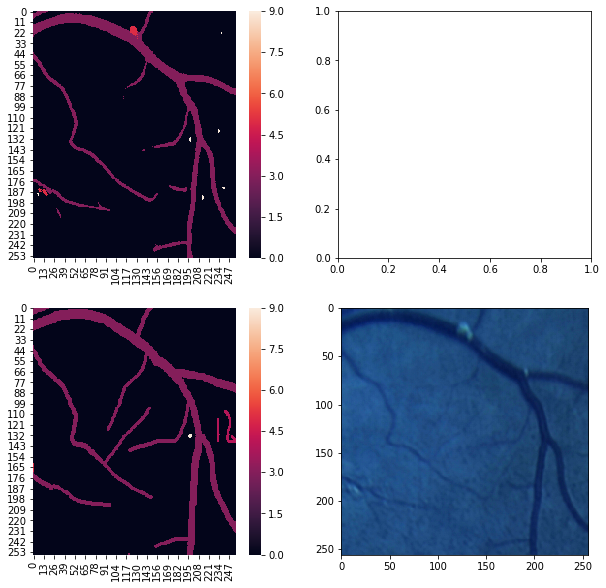

In [24]:
img_num = 0
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
sns.heatmap(predictions[img_num].argmax(axis=2), ax=axs[0][0])
sns.heatmap(Ytest[img_num], ax=axs[1][0])
plt.imshow(Xtest[img_num])

In [25]:
from makiflow.metrics import one_hot

In [27]:

EPSILON = 1e-9


def binary_dice(predicted, actual):
    num = np.sum(predicted * actual)
    den = np.sum(predicted * predicted) + np.sum(actual)
    return (2 * num + EPSILON) / (den + EPSILON)

In [28]:
P = predictions
L = labels
batch_sz = len(P)
L = np.asarray(L)
P = np.asarray(P)
print((P.argmax(axis=3) == 4).sum())
num_classes = P.shape[-1]

P = P.argmax(axis=3)
P = P.reshape(-1)
P = one_hot(P, depth=num_classes)
print((P.argmax(axis=2) == 4).sum())
P = P.reshape(batch_sz, -1, num_classes)
L = L.reshape(batch_sz, -1)

class_dices = np.zeros(num_classes)
class_counts = np.zeros(num_classes)
for i in range(batch_sz):
    sample_actual = L[i]
    sample_pred = P[i]
    for j in range(num_classes):
        sub_actual = (sample_actual[:] == j).astype(np.int32)
        sub_confs = sample_pred[:, j]
        if np.sum(sub_actual) == 0 and np.sum(sub_confs) == 0:
            continue
        class_dices[j] += binary_dice(sub_confs, sub_actual)
        class_counts[j] += 1


v_dice, dices = (class_dices / class_counts).mean(), class_dices / class_counts

In [29]:
class_counts

array([744., 227., 202., 744., 226., 537., 132.,  37., 307., 713.])

In [30]:
class_dices

array([7.04261878e+02, 1.40945246e+02, 7.99951855e+01, 4.77998786e+02,
       1.38647812e-01, 1.78131945e+02, 3.87881553e+01, 3.76822398e-09,
       6.63576772e+01, 3.37651839e+02])

In [13]:
(predictions.argmax(axis=-1) == 4).sum()

19

In [14]:
(labels == 4).sum()

95466

In [16]:
labels.shape

(744, 256, 256)

In [17]:
from makiflow.metrics import confusion_mat

In [18]:
confusion_mat(predictions, labels, use_argmax_p=True, to_flatten=True)

array([[0.93, 0.05, 0.36, 0.24, 0.26, 0.26, 0.2 , 0.93, 0.51, 0.26],
       [0.  , 0.91, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.03, 0.62, 0.  , 0.  , 0.21, 0.  , 0.  , 0.01, 0.  ],
       [0.04, 0.01, 0.01, 0.75, 0.11, 0.02, 0.  , 0.01, 0.01, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.51, 0.  , 0.06, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.79, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.45, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.71]],
      dtype=float32)

In [30]:
from sklearn.metrics import confusion_matrix

In [42]:
p = predictions
l = labels

p = p.argmax(axis=-1)

p = p.reshape(-1)
l = l.reshape(-1)

mat_un = np.asarray(confusion_matrix(l, p, labels=[i for i in range(10)],), dtype=np.float32)
mat = mat_un / mat_un.sum(axis=0)
mat = np.round(mat, decimals=2)

In [43]:
mat

array([[0.93, 0.05, 0.36, 0.24, 0.26, 0.26, 0.2 , 0.93, 0.51, 0.26],
       [0.  , 0.91, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.03, 0.62, 0.  , 0.  , 0.21, 0.  , 0.  , 0.01, 0.  ],
       [0.04, 0.01, 0.01, 0.75, 0.11, 0.02, 0.  , 0.01, 0.01, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.51, 0.  , 0.06, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.79, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.45, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.71]],
      dtype=float32)

In [49]:
mat_un

array([[3.918889e+07, 7.875000e+04, 3.448240e+05, 8.443890e+05,
        5.000000e+00, 6.926400e+04, 1.141700e+04, 3.380000e+02,
        6.173800e+04, 8.035600e+04],
       [8.025900e+04, 1.323622e+06, 0.000000e+00, 1.213700e+04,
        0.000000e+00, 0.000000e+00, 4.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.064780e+05, 3.849100e+04, 5.973750e+05, 2.190000e+02,
        0.000000e+00, 5.520900e+04, 1.090000e+02, 0.000000e+00,
        6.630000e+02, 9.940000e+02],
       [1.794729e+06, 1.677200e+04, 5.392000e+03, 2.698425e+06,
        2.000000e+00, 5.255000e+03, 4.500000e+01, 5.000000e+00,
        1.635000e+03, 6.498000e+03],
       [8.856500e+04, 0.000000e+00, 0.000000e+00, 4.963000e+03,
        1.200000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.926000e+03],
       [1.201120e+05, 2.132000e+03, 9.570000e+03, 8.777000e+03,
        0.000000e+00, 1.379180e+05, 7.000000e+00, 2.200000e+01,
        1.235000e+03, 1.500000e+01],
       [5.

In [47]:
mat = mat_un / mat_un.sum(axis=1)
mat = np.round(mat, decimals=2)

In [48]:
mat

array([[0.96, 0.06, 0.34, 0.19, 0.  , 0.25, 0.11, 0.07, 0.27, 0.19],
       [0.  , 0.93, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.03, 0.6 , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.01, 0.01, 0.6 , 0.  , 0.02, 0.  , 0.  , 0.01, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.49, 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.43, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.51]],
      dtype=float32)

In [34]:
np.unique(p[l == 4], return_counts=True)

(array([0, 3, 4, 9]), array([88565,  4963,    12,  1926]))

In [50]:
(l == 7).sum()

4894

In [52]:
(p == 7).sum()

365

In [53]:
365/4894

0.07458111973845526

In [36]:
def confusion_mat(
        p, l,
        use_argmax_p=False, use_argmax_l=False, to_flatten=False, normalize=[0, 1],
        save_path=None, dpi=150, annot=True
    ):
    """
    Creates confusion matrix for the given predictions `p` and labels `l`.
    Parameters
    ----------
    p : np.ndarray
        Predictions.
    l : np.ndarray
        Corresponding labels.
    use_argmax_p : bool
        Set to true if prediction aren't sparse, i.e. `p` is an array of shape [..., num_classes].
    use_argmax_l : bool
        Set to True if labels aren't sparse (one-hot encoded), i.e. `l` is an array of shape [..., num_classes].
    to_flatten : bool
        Set to True if `p' and `l` are high-dimensional arrays.
    normalize : list 
        List of axes. The matrix will be normalized along these axes.
        Axis 1 - normalizing by the number of true samples per class.
        Axis 0 - normalizing by the number of the network predictions per class.
        Leave the list empty if you unnormalized matrix.
    save_path : str
        Saving path for the confusion matrix picture.
    dpi : int
        Affects the size of the saved confusion matrix picture.
    annot : bool
        Set to true if you want to see actual numbers (classes) on the matrix picture.
    
    Returns
    -------
    list
        Confusion matrices.
    """
    if use_argmax_p:
        p = p.argmax(axis=-1)

    if use_argmax_l:
        l = l.argmax(axis=-1)

    if to_flatten:
        p = p.reshape(-1)
        l = l.reshape(-1)

    mat = np.asarray(confusion_matrix(l, p), dtype=np.float32)
    del p
    del l
    
    assert(len(normalize) < 3)
    
    if len(normalize) == 2:
        
        mats = []
        for i, ax in enumerate(normalize):
            temp_mat = mat / mat.sum(axis=ax)
            temp_mat = np.round(temp_mat, decimals=2)
            mats += [temp_mat]
            
        if save_path is not None:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6.4))
            sns.heatmap(mats[0], annot=annot, ax=axes[0])
            axes[0].set_title(f'Axis {normalize[0]}')
            sns.heatmap(mats[1], annot=annot, ax=axes[1])
            axes[1].set_title(f'Axis {normalize[1]}')
            fig.savefig(save_path)
            plt.close(fig)
        
        return mats
        
    
    if len(normalize) == 1:
        mat /= mat.sum(axis=normalize[0])
        mat = np.round(mat, decimals=2)

    if save_path is not None:
        conf_mat = sns.heatmap(mat, annot=annot)
        conf_mat.figure.savefig(save_path, dpi=dpi)
        plt.close(conf_mat.figure)
    return [mat]

In [37]:
confusion_mat(predictions[:1000], labels[:1000], use_argmax_p=True, to_flatten=True, normalize=[1,0], save_path='mat.png')

[array([[0.96, 0.06, 0.34, 0.19, 0.  , 0.25, 0.11, 0.07, 0.27, 0.19],
        [0.  , 0.93, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.01, 0.03, 0.6 , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  ],
        [0.04, 0.01, 0.01, 0.6 , 0.  , 0.02, 0.  , 0.  , 0.01, 0.02],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  , 0.49, 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.43, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.51]],
       dtype=float32),
 array([[0.93, 0.05, 0.36, 0.24, 0.26, 0.26, 0.2 , 0.93, 0.51, 0.26],
        [0.  , 0.91, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.01, 0.03, 0.62, 0.  , 0.  , 0.21, 0.  , 0.  , 0.01, 0.  ],
        [0.04, 0.01, 0.01, 0.75, 0.11, 0.02, 0.  , 0.01, 0.01, 0.0